# Topic Modeling using BERTopic

## Import libraries

In [15]:
!pip install spacy-transformers
!python3 -m spacy download en_core_web_trf
!pip install detokenize

# download spacy en in case you run on an error blow
#python -m spacy download en

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 7.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from transformers import pipeline
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

from snorkel.labeling import LabelingFunction
import re
from snorkel.preprocess import preprocessor
from textblob import TextBlob

import plotly.express as px
import plotly.graph_objects as go
import datetime                    

from tqdm import tqdm

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.stem import WordNetLemmatizer

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, PartOfSpeech, MaximalMarginalRelevance
from sklearn.metrics.pairwise import cosine_similarity

import spacy
import spacy_transformers
nlp = spacy.load("en_core_web_sm")

from detokenize.detokenizer import detokenize

[nltk_data] Downloading package wordnet to /Users/janice/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/janice/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load data

In [24]:
# Load df
df = pd.read_csv(
    "../data/ChatGPT-play-reviews-combined_sentiment.csv",
    encoding="utf-8",
)

# Load df
df_prev = pd.read_csv(
    "../data/chatgpt_short_clean_en.csv",
    encoding="utf-8",
)

df_long = pd.read_csv(
    "../data/ChatGPT-play-reviews_long-sentiment_plus.csv",
    encoding="utf-8",
)

# Load df
df_long_prev = pd.read_csv(
    "../data/chatgpt_long_clean_en.csv",
    encoding="utf-8",
)


In [46]:
print(len(df), len(df_long), len(df_prev), len(df_long_prev))

27922 34304 21352 34304


## Remove NAs

In [47]:
df_long = df_long.dropna(subset=['content'])
#df_long = df_long.dropna(subset=['appVersion'])

df = df.dropna(subset=['content'])
# df = df.dropna(subset=['appVersion'])

df_prev = df_prev.dropna(subset=['content'])
#df_prev = df_prev.dropna(subset=['appVersion'])

In [48]:
print(len(df), len(df_long), len(df_prev))

27922 34304 21352


## Delete reviews of one or two words

In [49]:
def has_multiple_words(text):
    words = text.split()
    return len(words) > 1

df = df[df['content'].apply(has_multiple_words)]
df_long = df_long[df_long['content'].apply(has_multiple_words)]


In [50]:
len(df)

27623

## Improving the topic model

#### Lemmatization

Removed lemmatization based on this discussion:

https://stackoverflow.com/questions/68127754/removal-of-stop-words-and-stemming-lemmatization-for-bertopic

In [51]:
import string 
import spacy
from spacy.lang.en.stop_words import STOP_WORDS 
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_lemma(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [token.lemma_.lower().strip() if token.lemma_ != "-PRON-" else token.lower_ for token in mytokens]
    # Removing stop words
    mytokens = [token for token in mytokens if token not in stop_words and token not in punctuations ]
    # return preprocessed list of tokens
    sentence = detokenize(mytokens)
    return sentence

In [52]:
df['content_lemm'] = df.content.apply(spacy_lemma)

#### Tuning parameters

In [53]:
docs = list(df.content.values)
docs_lemm = list(df.content_lemm.values)

In [26]:
# best model so far with 28 categories
# from bertopic.vectorizers import ClassTfidfTransformer
# from transformers.pipelines import pipeline

# ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
# embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
# main_representation_model = KeyBERTInspired()
# aspect_representation_model1 = PartOfSpeech("en_core_web_sm")
# aspect_representation_model2 = [KeyBERTInspired(top_n_words=30), 
#                                 MaximalMarginalRelevance(diversity=.5)]

# representation_model = {
#    "Main": main_representation_model,
#    "Aspect1":  aspect_representation_model1,
#    "Aspect2":  aspect_representation_model2 
# }

# vectorizer_model = CountVectorizer(min_df=2, stop_words = 'english')
# topic_model = BERTopic(nr_topics = 'auto', 
#                       vectorizer_model = vectorizer_model,
#                       min_topic_size = 60,
#                       n_gram_range = (1,2),
#                       #embedding_model=embedding_model, #"all-MiniLM-L6-v2",
#                       ctfidf_model=ctfidf_model,
#                       representation_model = representation_model)


In [54]:
# best model so far with 28 categories

from bertopic.vectorizers import ClassTfidfTransformer
from transformers.pipelines import pipeline

ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
embedding_model = pipeline("feature-extraction", model="distilbert-base-cased")
main_representation_model = KeyBERTInspired()
aspect_representation_model1 = PartOfSpeech("en_core_web_sm")
aspect_representation_model2 = [KeyBERTInspired(top_n_words=30), 
                                MaximalMarginalRelevance(diversity=.5)]

representation_model = {
   "Main": main_representation_model,
   "Aspect1":  aspect_representation_model1,
   "Aspect2":  aspect_representation_model2 
}

vectorizer_model = CountVectorizer(min_df=2, stop_words = 'english')
topic_model = BERTopic(nr_topics = 'auto', 
                      #vectorizer_model = vectorizer_model,
                      min_topic_size = 60,
                      n_gram_range = (1,2),
                      #embedding_model="all-MiniLM-L6-v2", #"all-MiniLM-L6-v2",
                      ctfidf_model=ctfidf_model,
                      representation_model = representation_model)

In [55]:
X = vectorizer_model.fit_transform(docs_lemm)
vocabulary = vectorizer_model.get_feature_names_out()
print(len(vocabulary))

5581


In [56]:
topics, ini_probs = topic_model.fit_transform(docs_lemm)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [60]:
labels = topic_model.generate_topic_labels(topic_prefix=False, nr_words=2, separator=" & ")
print(labels)

['use chatgpt & chatgpt', 'latex & equation', 'student app & app study', 'conversation chatgpt & app chatgpt', 'account login & login account', 'ai tool & ai software', 'app voice & use voice', 'app error & fix app', 'good & good good', 'chat history & chat menu', 'hindi language & app hindi', 'picture app & image app', '2021 information & information 2021', 'app openai & openai app', 'helpful & helpful helpful', 'gpt app & app gpt', 'app ipad & ipad app', 'version app & web app', 'helpful application & useful application', 'code color & highlighting code', 'pay subscription & pay app', 'official app & app finally', 'app star & star app', 'review help & review', 'write story & create story', 'love app & app love', 'bias ideologically & ai censor', 'datum update & update datum', 'edit prompt & prompt editing', 'future future & future', 'review app & reviewer app', 'overheat app & app overheat', 'app update & update app', 'wait app & app wait', 'thank thank & thank', 'good ai & ai good',

In [61]:
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    topics_info_df['Label'] = topic_model.generate_topic_labels(topic_prefix=False, nr_words=2, separator=" & ")
    topics_info_df['Label'] = topics_info_df['Label'].str.title()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 'Label',
                           'Name', 'Representation'] + extra_cols]

topics_info_df = get_topic_stats(topic_model, ['Aspect1', 'Aspect2'])

In [62]:
topics_info_df

,Topic,Count,Share,CumulativeShare,Label,Name,Representation,Aspect1,Aspect2
0,-1,6877,24.895920,24.895920,Use Chatgpt & Chatgpt,-1_use chatgpt_chatgpt_app use_application,"[use chatgpt, chatgpt, app use, application, u...","[thank, time, help, lot, feature, download, re...","[use chatgpt, use app, chat, text, developer, ..."
1,0,5407,19.574268,44.470188,Latex & Equation,0_latex_equation_help lot_helpful student,"[latex, equation, help lot, helpful student, u...","[useful, answer, helpful, student, tool, easy,...","[latex, equation, useful student, homework, ma..."
2,1,3190,11.548347,56.018535,Student App & App Study,1_student app_app study_app student_helpful app,"[student app, app study, app student, helpful ...","[great app, nice app, helpful app, student, am...","[student app, app study, app student, app help..."
3,2,2680,9.702060,65.720595,Conversation Chatgpt & App Chatgpt,2_conversation chatgpt_app chatgpt_recommend c...,"[conversation chatgpt, app chatgpt, recommend ...","[chatgpt, conversation, engage, language, natu...","[conversation chatgpt, conversational, ai lang..."
4,3,1607,5.817616,71.538211,Account Login & Login Account,3_account login_login account_login microsoft_...,"[account login, login account, login microsoft...","[login, number, account, sign, log, phone, ema...","[account login, login microsoft, app login, tr..."
5,4,855,3.095247,74.633458,Ai Tool & Ai Software,4_ai tool_ai software_tool ai_good ai,"[ai tool, ai software, tool ai, good ai, ai go...","[ai, tool, world, chat, good, powerful, assist...","[tool ai, ai assistant, useful ai, ai ai, ai a..."
6,5,570,2.063498,76.696955,App Voice & Use Voice,5_app voice_use voice_voice text_voice feature,"[app voice, use voice, voice text, voice featu...","[voice, speech, text, audio, siri, speak, feat...","[app voice, voice command, voice message, voic..."
7,6,524,1.896970,78.593925,App Error & Fix App,6_app error_fix app_app bug_app crash,"[app error, fix app, app bug, app crash, app f...","[crash, freeze, network, bug, error, open, fix...","[app error, app freeze, request fail, crash ap..."
8,7,402,1.455309,80.049234,Good & Good Good,7_good_good good_good till_good great,"[good, good good, good till, good great, great...","[good, great, tis, , , , , , , ]","[till good, yes good, good wonderful, bro good..."
9,8,334,1.209137,81.258372,Chat History & Chat Menu,8_chat history_chat menu_history chat_turn chat,"[chat history, chat menu, history chat, turn c...","[scroll, history, chat, open, annoying, previo...","[chat history, chat menu, scroll chat, history..."


In [63]:
topic_model.get_topic(44)

False

In [44]:
from bertopic import BERTopic

from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS 
from spacy.lang.en import English

stop_words = spacy.lang.en.stop_words.STOP_WORDS

from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# umap_model = UMAP(n_neighbors=3, n_components=3, min_dist=0.05)
# hdbscan_model = HDBSCAN(min_cluster_size=80, min_samples=40,
#                         gen_min_span_tree=True,
#                         prediction_data=True)

# we add this to remove stopwords that can pollute topcs
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=(list(stop_words)))

model = BERTopic(
    #umap_model=umap_model,
    #hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    language='english',
    calculate_probabilities=True,
    verbose=True
)
topics, ini_probs = model.fit_transform(docs)

Batches:   0%|          | 0/559 [00:00<?, ?it/s]

2023-11-04 14:08:41,860 - BERTopic - Transformed documents to Embeddings
2023-11-04 14:08:59,786 - BERTopic - Reduced dimensionality
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` befo

In [106]:
def get_topic_stats(model, extra_cols = []):
    topics_info_df = model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 
                           'Name', 'Representation'] + extra_cols]

get_topic_stats(model)

,Topic,Count,Share,CumulativeShare,Name,Representation
0,-1,5800,32.462081,32.462081,-1_chatgpt_app_like_use,"[chatgpt, app, like, use, good, ai, great, wor..."
1,0,357,1.998097,34.460178,0_answers_answer_questions_response,"[answers, answer, questions, response, wrong, ..."
2,1,343,1.919740,36.379918,1_students_study_studies_student,"[students, study, studies, student, good stude..."
3,2,334,1.869368,38.249286,2_voice_speech_text_feature,"[voice, speech, text, feature, text speech, au..."
4,3,302,1.690267,39.939553,3_2021_september_september 2021_update,"[2021, september, september 2021, update, upda..."
...,...,...,...,...,...,...
282,281,10,0.055969,99.776124,281_unexpected good_unbelievable unexpected_li...,"[unexpected good, unbelievable unexpected, lif..."
283,282,10,0.055969,99.832093,282_website_mobile version_website chatgpt_line,"[website, mobile version, website chatgpt, lin..."
284,283,10,0.055969,99.888062,283_impressed issue_dearly_app resourceful_tho...,"[impressed issue, dearly, app resourceful, tho..."
285,284,10,0.055969,99.944031,284_fast_reliable_use fast_fast reliable,"[fast, reliable, use fast, fast reliable, fast..."


In [197]:
topic_model.get_representative_docs(40)

['excellent generate answer especially creative answer writing lack mathematics equation text messylike computerized process properly study write proper equation example write like thissinfracsqrt2h2cosx fracsqrt2 .. like literally symbol hope fix thankyou helpful study .. ️',
 'cool definitely recommend try chatgpt4 annoying thing encounter ask math question respond use latex syntax lot hard understand try especially try explain concept use lot latex example ask complex formula fracpartial2 psipartial habla psi wave equation',
 'notice limitation app compare web counterpart instance web version display mathematical notation app example fracddx basic calculus formula appear complex app presentation style copy paste style like web version solve problem soon possible']

## Add topics to df

In [95]:
df_topic = pd.DataFrame({"Topic": topics}) #, "content": docs})

In [96]:
df_merged = pd.merge(df, df_topic, left_index=True, right_index=True)
df_merged = pd.merge(df_merged, topics_info_df[['Topic', 'Count', 'Share', 'Name', 'Label', 'Representation', 'Aspect1', 'Aspect2']], on='Topic')


In [97]:
df_merged.groupby('Label').mean('blob_subjectivity')['blob_subjectivity']

Label
2021 Information & Information 2021         0.462377
Account Login & Login Account               0.346589
Ai Tool & Ai Software                       0.513419
App Attic & Feedback App                    0.633788
App Error & Fix App                         0.414621
App Ipad & Ipad App                         0.463599
App Openai & Openai App                     0.518087
App Playstore & App Store                   0.521574
App Star & Star App                         0.500785
App Update & Update App                     0.590172
App Voice & Use Voice                       0.495258
Bias Ideologically & Ai Censor              0.487055
Chat History & Chat Menu                    0.444433
Code Color & Highlighting Code              0.433143
Conversation Chatgpt & App Chatgpt          0.538980
Datum Update & Update Datum                 0.488529
Edit Prompt & Prompt Editing                0.398378
Expect App & Expect Feature                 0.472471
Future Future & Future                  

In [98]:
df_merged['at_w'] = pd.to_datetime(df_merged['at']).dt.isocalendar().week


In [99]:
def week_to_date(week):
    date = datetime.date(2023, 1, 2) + datetime.timedelta(days=(week - 1) * 7)
    return date

In [100]:
df_merged['at_wy'] = df_merged['at_w'].apply(week_to_date)

In [101]:
df_merged.to_csv("../data/chatgpt-combined_short_topics.csv", index=False)

In [104]:
df_merged.columns

Index(['at', 'score', 'userName', 'content', 'Source', 'reviewId',
       'thumbsUpCount', 'replyContent', 'repliedAt', 'appVersion', 'reply',
       'Reviews', 'at_ymd', 'at_q', 'at_ym', 'at_m', 'at_wd', 'at_w',
       'score_cat', 'detected_language', 'category', 'positive_score',
       'neutral_score', 'negative_score', 'vader_cat', 'vader_neg',
       'vader_neu', 'vader_pos', 'blob_polarity', 'blob_subjectivity',
       'content_lemm', 'Topic', 'Count', 'Share', 'Name', 'Label',
       'Representation', 'Aspect1', 'Aspect2', 'at_wy'],
      dtype='object')

### Visualization

In [2]:
c1 = '#c0791b'
c2 = '#599191'
c3 = '#5f5f5f'
c4 = '#1b786e'   
c5 = '#202112'

# release_1 =
# release_2 = 

In [5]:
df= pd.read_csv("../data/chatgpt-combined_short_topics.csv")

In [88]:
for var in ['category']:
    for t in range(0, 3, 1):
        df_chart = df_merged[df_merged['Topic'] == t].groupby(['at_wy',var]).size().reset_index(name='Reviews').sort_values([var, 'at_wy'], ascending=False)
        fig = px.line(df_chart, 
            y='Reviews', 
            x='at_wy',
            title=" Weekly Reviews for the Topic<br>" + df_merged[df_merged['Topic'] == t]['Label'].iloc[0],
            labels={'at_wy': 'Review Week'},
            text='Reviews',
            template='ggplot2',
            hover_data={"at_wy": "|%B %d, %Y"},
            color=var,
            color_discrete_sequence=[c1, c2, c3, c4, c5])
        fig.update_traces(textposition='top center')
        fig.update_layout(legend_title_text=var.capitalize())
        fig.update_xaxes(
            # tick0="2023-08-15",
            # dtick="M1",
            tickformat='%d/%m/%Y ', 
            overwrite = True)
        fig.add_annotation(
            x=datetime.date(2023, 10, 1)
            , y=np.max(df_chart['Reviews']) + 10
            , text=f'New AppVersion  <br> Release'
            , yanchor='top'
            , showarrow=False
            # , arrowhead=1
            # , arrowsize=1
            # , arrowwidth=2
            # , arrowcolor="#636363"
            , ax=-20
            , ay=-30
            #, font=dict(size=12, color="purple", family="Courier New, monospace")
            , align="center"
            ,)
        fig.add_vline(
            x=datetime.date(2023, 10, 1), 
            line_width=3, 
            line_dash="dot", 
            line_color="grey")
        # # add vertical lines
        # fig.update_layout(shapes=
        #             [dict(type= 'line',
        #                     yref= 'paper', y0= 0, y1= 1,
        #                     xref= 'x', x0='2023-08-21', x1='2023-08-21',
        #                     line=dict(color=c1,
        #                             width=3,
        #                             dash="dot")
        #                     )
        #             ])
        fig.show()


In [270]:
np.max(df_chart['Reviews (%)'])

78.26086956521739

In [6]:
import datetime as dt

In [7]:
f=13

In [23]:
for var in ['category']:
    for t in [6]:
        df_chart = df[df['Topic'] == t].groupby(['at_wy',var]).size().reset_index(name='Reviews').sort_values([var, 'at_wy'], ascending=False) 
        df_chart['Reviews (%)'] = df_chart.groupby('at_wy')['Reviews'].transform(lambda x: x / x.sum() * 100)
        max_cat = df_chart[var].iloc[np.argmax(df_chart['Reviews (%)'])]
        max_val = np.max(df_chart['Reviews (%)'])
        fig = px.line(df_chart, 
            y='Reviews (%)', 
            x='at_wy',
            labels={'at_wy': 'Review Week'},
            text = np.where(df_chart[var]=='negative' ,df_chart['Reviews (%)'], " "), 
            title="Weekly Reviews for the Topic<br>" + df[df['Topic'] == t]['Label'].iloc[0],
            template='ggplot2',
            hover_data={"at_wy": "|%B %d, %Y"},
            color=var,
            color_discrete_sequence=[c1, c2, c3, c4, c5])
        fig.update_traces(
            textposition='top center',
            texttemplate= "%{text:2.0f}%",
            selector = ({'name':'negative'}))
        fig.update_layout(
            height=600,
            width=1300,
            legend_title_text=var.capitalize(),
            font=dict(size=f),
            xaxis_title="Review Week",
            xaxis_title_font_size=f,
            xaxis_tickfont_size=f,
            yaxis_title="Reviews (%)",
            yaxis_title_font_size=f,
            yaxis_tickfont_size=f, 
            legend_font_size=f,
            legend_title = dict(font = dict(size = f)))
        fig.update_xaxes(
            tickformat='%d/%m/%Y', 
            overwrite = True)
        fig.add_annotation(
            x=dt.date(2023, 10, 1)
            , y=np.max(df_chart['Reviews (%)']) + 10
            , text=f'New AppVersion  <br> Release'
            , yanchor='top'
            , showarrow=False
            , ax=-20
            , ay=-30
            , align="center"
            ,)
        fig.add_vline(
            x=dt.date(2023, 10, 1), 
            line_width=3, 
            line_dash="dot", 
            line_color="grey")
        fig.show()

In [107]:
topic_model.visualize_barchart(top_n_topics = 21, n_words = 10, width=400)

In [110]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

UsageError: Line magic function `%` not found.


In [133]:
import matplotlib.pyplot as plt

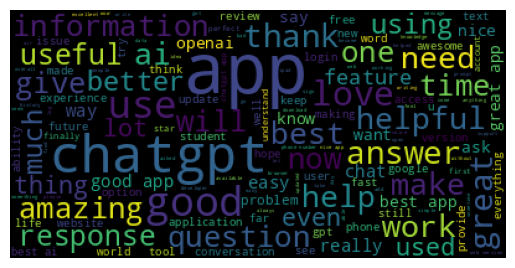

In [136]:
#Instantiate wordcloud object and use method to feed it our corpus
wc = WordCloud().generate_from_text(' '.join(df_merged['content']))

#Use matplotlib.pyplot to display the fitted wordcloud
#Turn axis off to get rid of axis numbers
plt.imshow(wc)
plt.axis('off')
plt.show()

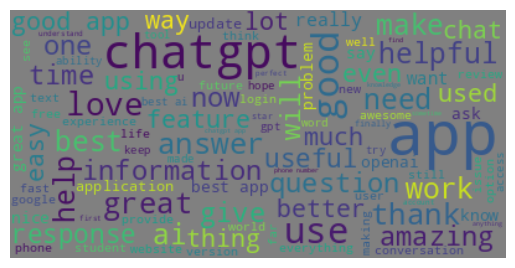

<Figure size 1000x1000 with 0 Axes>

In [134]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="grey", contour_color="grey", contour_width=0).generate(' '.join(df_merged['content']))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.tight_layout(pad=0)
plt.figure(figsize=(10,10))
plt.show()

# wordcloud = WordCloud().generate(text)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.figure(figsize=(10,10))
# plt.show()

In [156]:
topic_model.visualize_topics()

### Embedding model

## Search topics

Note: You can only use this method if an embedding model was supplied to BERTopic using embedding_model.

In [226]:
similar_topics, similarity = topic_model.find_topics("voice", top_n=5)
topic_model.get_topic(similar_topics[0])

[('voicetotext', 0.7687919),
 ('voice', 0.64830846),
 ('speechtotext', 0.62790406),
 ('microphone', 0.5031773),
 ('audio', 0.48563433),
 ('speech', 0.46069753),
 ('transcription', 0.45139158),
 ('speaker', 0.41808367),
 ('text', 0.41523013),
 ('speak', 0.40731138)]

## Topics per Class 

### App Rating (positive, neutral, negative)

In [167]:
topics_per_class = topic_model.topics_per_class(docs, classes=df.score_cat)
fig = topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=15, 
                                      normalize_frequency = True)

fig.write_html('basic.html')
fig.show()

### App Version 

In [ ]:
# Load df
df = pd.read_csv(
    "../data/ChatGPT-play-reviews_sentiment.csv",
    encoding="utf-8",
)

df_long = pd.read_csv(
    "../data/ChatGPT-play-reviews_long-sentiment_plus.csv",
    encoding="utf-8",
)

In [189]:
df_version = df.dropna(subset=['appVersion'])

In [199]:
df_version['content'] = df_version['content'].apply(lemmatizer)

In [200]:
docs = list(df_version.content.values)
topic_model = BERTopic()

In [201]:
main_representation_model = KeyBERTInspired()
aspect_representation_model1 = PartOfSpeech("en_core_web_sm")
aspect_representation_model2 = [KeyBERTInspired(top_n_words=30), 
                                MaximalMarginalRelevance(diversity=.5)]

representation_model = {
   "Main": main_representation_model,
   "Aspect1":  aspect_representation_model1,
   "Aspect2":  aspect_representation_model2 
}

vectorizer_model = CountVectorizer(min_df=2, stop_words = 'english')
topic_model = BERTopic(nr_topics = 'auto', 
                      vectorizer_model = vectorizer_model,
                      representation_model = representation_model)

topics, ini_probs = topic_model.fit_transform(docs)
def get_topic_stats(topic_model, extra_cols = []):
    topics_info_df = topic_model.get_topic_info().sort_values('Count', ascending = False)
    topics_info_df['Share'] = 100.*topics_info_df['Count']/topics_info_df['Count'].sum()
    topics_info_df['CumulativeShare'] = 100.*topics_info_df['Count'].cumsum()/topics_info_df['Count'].sum()
    return topics_info_df[['Topic', 'Count', 'Share', 'CumulativeShare', 
                           'Name', 'Representation'] + extra_cols]

get_topic_stats(topic_model, ['Aspect1', 'Aspect2']).head(25)\
    .set_index('Topic')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

,Count,Share,CumulativeShare,Name,Representation,Aspect1,Aspect2
Topic,,,,,,,
0,6644,37.185873,37.185873,0_chatgpt_app_chat_android,"[chatgpt, app, chat, android, openai, conversa...","[app, chatgpt, helpful, useful, update, good, ...","[chatgpt, app, openai, conversation, ai, devel..."
-1,5975,33.441540,70.627414,-1_chatgpt_app_android_chat,"[chatgpt, app, android, chat, application, mob...","[chatgpt, app, use, good, work, answer, ai, th...","[chatgpt, app, ai, useful, developer, conversa..."
1,332,1.858174,72.485588,1_awesome_tomorrow_hype_wanna,"[awesome, tomorrow, hype, wanna, super, specta...","[awesome, amazing, cool, good, great, ride, to...","[awesome, tomorrow, hype, spectacular, usual, ..."
2,246,1.376840,73.862428,2_voicetotext_voice_speechtotext_microphone,"[voicetotext, voice, speechtotext, microphone,...","[voice, speech, text, audio, feature, input, r...","[voicetotext, transcription, alexa, pause, sir..."
3,202,1.130576,74.993004,3_openai_thank_thanks_happy,"[openai, thank, thanks, happy, forward, respec...","[openai, team, thank, application, product, ma...","[openai, thank, respect, introduce, feature, f..."
4,180,1.007444,76.000448,4_answer_response_reply_inquiry,"[answer, response, reply, inquiry, ask, questi...","[answer, question, wrong, correct, additional,...","[reply, matter, wisdom, allot, point, plant, s..."
5,160,0.895506,76.895953,5_image_photo_camera_picture,"[image, photo, camera, picture, upload, graphi...","[image, picture, photo, camera, video, scan, p...","[upload, scan, caption, text, lens, display, g..."
6,148,0.828343,77.724296,6_number_phone_cellphone_register,"[number, phone, cellphone, register, require, ...","[number, phone, verification, landline, code, ...","[number, register, need, mobile, landline, pas..."
7,146,0.817149,78.541445,7_gpt_gpt35_masse_good,"[gpt, gpt35, masse, good, case, nt, support, m...","[gpt, free, use, version, web, bad, quality, a...","[gpt35, masse, case, nt, quality, pixel, peak,..."


In [202]:
topics_per_class = topic_model.topics_per_class(docs, classes=df_version.appVersion)

In [203]:
fig = topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=15, 
                                      normalize_frequency = True)

fig.write_html('basic.html')
fig.show()

## Timeline / Deep-dive EDA

In [184]:
#docs = list(df.content.values)
#topic_model = BERTopic()

In [334]:
df_neg_top15 = df_merged[(df_merged["score_cat"] == "negative") & (df_merged["topic"]< 15)]

In [313]:
df_negative = df_merged[(df_merged["score_cat"] == "negative") & (df_merged["topic"] == 6)]

In [285]:
df_negative.columns

Index(['Unnamed: 0', 'reviewId', 'userName', 'content', 'score',
       'thumbsUpCount', 'at', 'replyContent', 'repliedAt', 'appVersion',
       'at_ymd', 'at_q', 'at_ym', 'at_m', 'at_wd', 'score_cat',
       'detected_language', 'topic'],
      dtype='object')

In [314]:
df_negative['at'] = pd.to_datetime(df_negative['at'])
df_negative['at'].sort_values()

7596    2023-07-25 17:17:30
9591    2023-07-25 17:22:33
2498    2023-07-25 17:37:55
9540    2023-07-25 19:05:41
9346    2023-07-26 06:10:46
                ...        
1174    2023-10-17 12:40:37
1476    2023-10-18 07:36:17
207     2023-10-20 04:01:11
27540   2023-10-21 13:15:15
9520    2023-10-21 15:18:35
Name: at, Length: 83, dtype: datetime64[ns]

In [320]:
df_negative["week_number"] = df_negative['at'].dt.isocalendar().week

In [329]:
week_count = df_negative.groupby('week_number')['reviewId'].count().reset_index()
week_count

,week_number,reviewId
0,30,17
1,31,14
2,32,3
3,33,5
4,34,3
5,35,4
6,36,4
7,37,3
8,38,4
9,39,6


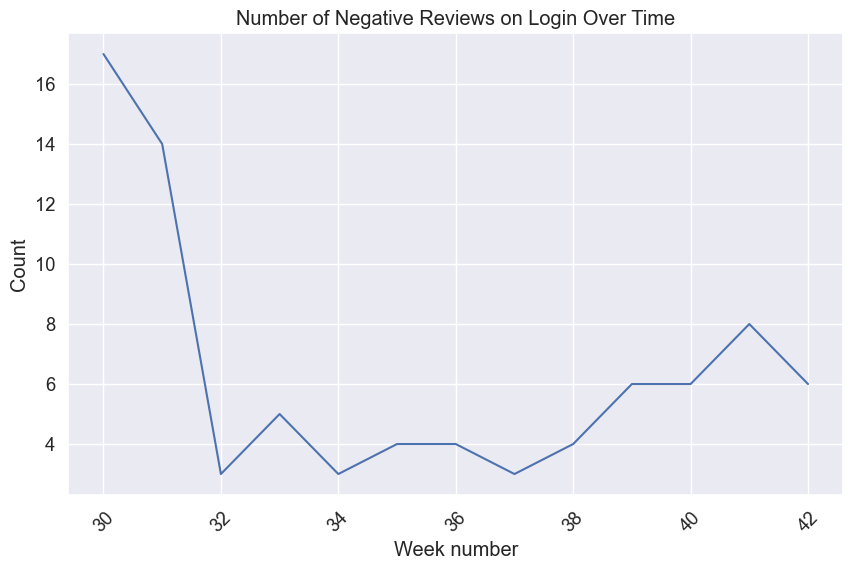

In [337]:
plt.figure(figsize=(10, 6))
plt.plot(week_count["week_number"], week_count["reviewId"])
plt.xlabel('Week number')
plt.ylabel('Count')
plt.title('Number of Negative Reviews on Login Over Time')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

[Text(0.5, 0, 'Topic'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Distribution of Topics')]

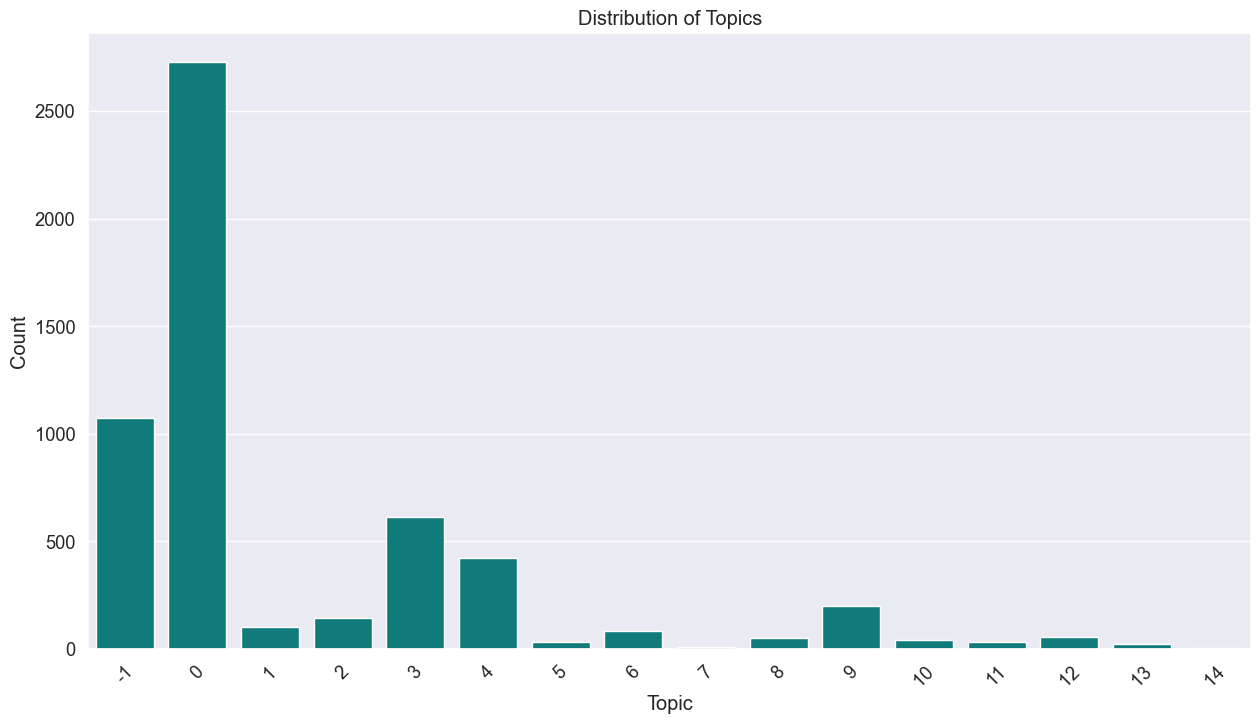

In [335]:
# Countplot shows the distribution of Publication
plt.rcParams['figure.figsize'] = [15, 8]
sns.set(font_scale = 1.2, style = 'darkgrid')
sns_year = sns.countplot(x=df_neg_top15['topic'], color = 'darkcyan')
plt.xticks(rotation=45)
sns_year.set(xlabel = "Topic", ylabel = "Count", title = "Distribution of Topics")

In [ ]:
sns.lineplot(data=df_negative, x="month", y="passengers")

In [185]:
topics_per_class = topic_model.topics_per_class(docs, classes=df.at_m)
fig = topic_model.visualize_topics_per_class(topics_per_class, top_n_topics=15, 
                                      normalize_frequency = True)

fig.write_html('basic.html')
fig.show()

ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [165]:
df.head()

,Unnamed: 0,reviewId,userName,content,score,thumbsUpCount,at,replyContent,repliedAt,appVersion,at_ymd,at_q,at_ym,at_m,at_wd,score_cat,detected_language
0,0,36b7f28e-151d-4b98-8a13-41bd017e0d25,Lin Cheng,chatgpt on android is a solid app with seamles...,4,5,2023-10-19 19:26:19,NaN,NaN,1.2023.284,10/19/23,4,2023-10,October,Thursday,neutral,en
1,1,2bc253b6-c804-47e9-b6f2-3a21027efab4,Alim,i've been using chatgpt for a while but i've j...,5,139,2023-09-29 20:24:38,NaN,NaN,1.2023.263,09/29/23,3,2023-09,September,Friday,positive,en
2,2,5f084727-ab85-40b3-bd42-a7a49502fc1f,Theo Healy,the chatgpt android app has completely blown m...,4,247,2023-07-28 10:29:10,NaN,NaN,1.0.0023,07/28/23,3,2023-07,July,Friday,neutral,en
3,3,5df90de5-b8e2-4dc2-b6ff-520aa3a25eae,Elliot Limberg,no subscription free and accurate unbiased ans...,5,272,2023-07-30 19:38:37,NaN,NaN,1.0.0023,07/30/23,3,2023-07,July,Sunday,positive,en
4,4,bb66c666-865d-4a31-b27f-4933df3ff829,Phoebe Moraes,i use this app for learning languages which ch...,4,126,2023-08-09 18:23:33,NaN,NaN,1.0.0030,08/09/23,3,2023-08,August,Wednesday,neutral,en


Summary: 
- Bugs with login, other errors  
- Educational purpose, studying 
- Helping, Assistance 
- Phone number for registration needed, verification
- Feature request on uploading photos, gettung responses with images 
- Translation problems for hindi speakers 
- future-oriented topic

## Dealing with Outliers

-1 represents outliers: 6841! 

In [67]:
percentage_outliers = (6841 / 22371)*100 
percentage_outliers

30.579768450225735

Four different strategies to deal with the outliers:
1. based on topic-document probabilities,
2. based on topic distributions,
3. based on c-TF-IFD representations,
4. based on document and topic embeddings.

## Reducing the number of topics

In [158]:
topic_model.visualize_heatmap(n_clusters = 20)

In [159]:
distance_matrix = cosine_similarity(np.array(topic_model.topic_embeddings_))
dist_df = pd.DataFrame(distance_matrix, columns=topic_model.topic_labels_.values(), 
                       index=topic_model.topic_labels_.values())

tmp = []
for rec in dist_df.reset_index().to_dict('records'):
    t1 = rec['index']
    for t2 in rec:
        if t2 == 'index': 
            continue
        tmp.append(
            {
                'topic1': t1, 
                'topic2': t2, 
                'distance': rec[t2]
            }
        )

pair_dist_df = pd.DataFrame(tmp)

pair_dist_df = pair_dist_df[(pair_dist_df.topic1.map(
      lambda x: not x.startswith('-1'))) & 
            (pair_dist_df.topic2.map(lambda x: not x.startswith('-1')))]
pair_dist_df = pair_dist_df[pair_dist_df.topic1 < pair_dist_df.topic2]
pair_dist_df.sort_values('distance', ascending = False).head(20)

,topic1,topic2,distance
40635,200_android_app_native_phone,32_android_mobile_finally_os,0.887677
9373,45_review_reviewer_follow_complaint,80_review_reviewer_rating_thank,0.887035
28134,138_use_easy_simple_easily,55_useful_use_practical_handy,0.885001
377,0_app_application_use_download,174_app_experience_use_wonderful,0.878171
346,0_app_application_use_download,143_app_interesting_neat_curious,0.869638
426,1_chatgpt_conversation_conversational_chat,21_chatgpt_openai_chat_android,0.855959
22378,109_grammar_grammatical_editing_speech,157_app_language_application_translation,0.854126
4889,23_app_2021_2023_currentupdate,40_app_improvement_improve_appian,0.853135
27043,132_chatgpt_chatgpts_login_unable,176_chatgpt_unable_error_wifi,0.851943
3677,17_app_webview_mobile_version,40_app_improvement_improve_appian,0.850428


### Merging

Intentionally left blank as we should take a deeper look into the clusters to see what can be merged

In [ ]:
#topic_model.merge_topics(docs, [[26, 74], [43, 68, 62], [16, 50, 91]])
#df['merged_topic'] = topic_model.topics_

## Topic Distributions

In [160]:
topic_distr, topic_token_distr = topic_model.approximate_distribution(
      docs, window = 4, calculate_tokens=True)

In [161]:
topic_model.visualize_distribution(topic_distr[1])

In [162]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs, calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(docs[1], topic_token_distr[1])
df

,have,be,use,chatgpt,for,while,but,have,just,test,out,the,microphone,speech,recognition,option,for,the,first,time,and,let,we,say,be,completely,blow,away,no,seriously,it,literally,put,all,the,expression,punctuation,in,the,right,place,no,matter,how,you,talk,it,convert,it,without,problem,it,be,amazing,and,will,probably,will,never,type,to,chatgpt,again,still,though,that,be,some,outstanding,work,now,we,wait,for,voice,response,from,the,both,hopefully
0_app_application_use_download,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.139,0.314,0.489,0.489,0.350,0.175,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_chatgpt_conversation_conversational_chat,0.205,0.410,0.614,0.863,0.658,0.453,0.248,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.248,0.497,0.497,0.497,0.248,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.106,0.106,0.106,0.000
3_awesome_hopefully_hype_wanna,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.139,0.397,0.655,0.655,0.516,0.258,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5_login_password_reinstall_unable,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.137,0.273,0.410,0.547,0.410,0.273,0.137,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6_voicetotext_voice_speechtotext_microphone,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.225,0.503,0.794,1.118,1.077,0.798,0.508,0.184,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.443,0.877,1.430,1.982,1.539,1.105,0.553,0.000,0.000
10_answer_reply_question_ask,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.110,0.110,0.110,0.110,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
12_image_photo_pic_picture,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.129,0.129,0.129,0.129,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,

TO-DO: 

- append topic names to df 
- merge similar topics
